In [17]:
# import necessary libraries
import requests
from sodapy import Socrata
import pandas as pd
import plotly.plotly as py
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# define the API call as the CFPB Consumer Complaints Database
cfpb_dataset = 'data.consumerfinance.gov'

# CSV file for ACS 2017 Median Household Income statistics
census_dataset = 'acs_income_dataset.csv'

In [19]:
# initialize an empty list which will be used to hold the dataframes
dfs = []

# open the file which stores the CCDB API key
f = open("ccdb_api.key", "r")

# store the API key value in a variable
api_key = f.readline()

In [20]:
# function to call the CCDB API in batches
def batch_retrieve(api_call):
    
    # call the API
    client = Socrata(api_call, api_key)
    
    # "i" is the record number where each batch API call starts
    i = 0
    for df in dfs:
        i += len(df)
    
    # get the results with the CCDB API
    results = client.get("s6ew-h6mp", offset = i, limit=100)
    
    # turn the results into a dataframe
    results_df = pd.DataFrame.from_records(results)
    
    # append all dataframes to a list (dfs)
    dfs.append(results_df)

# function to programmatically call batch_receive
def retrieve_and_concatenate(num_dfs,filename):
    
    # for loop that loops through the number of dataframes in dfs
    for i in range(num_dfs):
        
        batch_retrieve(cfpb_dataset)
    
    # concatenate all dataframes in dfs into one dataframe
    df = pd.concat(dfs, sort=True)
    
    # pickle the file
    df.to_pickle(filename)

In [79]:
retrieve_and_concatenate(100,"state_complaints.csv")

In [80]:
pd.read_pickle("state_complaints.csv")
# This dataset has 250,000 records

,company,company_public_response,company_response,complaint_id,complaint_what_happened,consumer_consent_provided,consumer_disputed,date_received,date_sent_to_company,issue,product,state,sub_issue,sub_product,submitted_via,tags,timely,zip_code
0,TRANSWORLD SYSTEMS INC,NaN,Closed with explanation,2943295,NaN,Consent not provided,N/A,2018-06-22T00:00:00.000,2018-06-22T00:00:00.000,Written notification about debt,Debt collection,NaN,Didn't receive notice of right to dispute,Other debt,Web,NaN,Yes,NaN
1,WELLS FARGO & COMPANY,Company has responded to the consumer and the ...,Closed with monetary relief,2725425,NaN,N/A,N/A,2017-11-09T00:00:00.000,2017-11-09T00:00:00.000,Managing an account,Checking or savings account,WA,Problem using a debit or ATM card,Checking account,Phone,NaN,Yes,98362
2,"PMAB,LLC",NaN,Closed with explanation,2710614,NaN,N/A,N/A,2017-10-24T00:00:00.000,2017-10-24T00:00:00.000,Written notification about debt,Debt collection,SC,Didn't receive enough information to verify debt,Other debt,Postal mail,NaN,No,29666
3,Ditech Financial LLC,Company believes it acted appropriately as aut...,Closed with explanation,2371574,NaN,Consent not provided,No,2017-03-04T00:00:00.000,2017-03-04T00:00:00.000,"Loan servicing, payments, escrow account",Mortgage,MI,NaN,Conventional fixed mortgage,Web,NaN,Yes,48328
4,JPMORGAN CHASE & CO.,NaN,Closed with monetary relief,2432049,NaN,N/A,No,2017-04-12T00:00:00.000,2017-04-13T00:00:00.000,Deposits and withdrawals,Bank account or service,CA,NaN,Other bank product/service,Referral,NaN,Yes,91913
5,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Company has responded to the consumer and the ...,Closed with explanation,2556286,NaN,Consent not provided,N/A,2017-06-22T00:00:00.000,2017-06-22T00:00:00.000,Improper use of your report,"Credit reporting, credit repair services, or o...",TX,Credit inquiries on your report that you don't...,Credit reporting,Web,NaN,Yes,75165
6,WELLS FARGO & COMPANY,Company has responded to the consumer and the ...,Closed with explanation,2780746,NaN,Consent not provided,N/A,2018-01-13T00:00:00.000,2018-01-13T00:00:00.000,"Other features, terms, or problems",Credit card or prepaid card,NJ,Other problem,General-purpose credit card or charge card,Web,NaN,Yes,07003
7,Experian Information Solutions Inc.,Company has responded to the consumer and the ...,Closed with explanation,2722244,NaN,N/A,N/A,2017-11-06T00:00:00.000,2017-11-06T00:00:00.000,Problem with a credit reporting company's inve...,"Credit reporting, credit repair services, or o...",NJ,Their investigation did not fix an error on yo...,Credit reporting,Fax,NaN,Yes,07111
8,"BANK OF AMERICA, NATIONAL ASSOCIATION",Company has responded to the consumer and the ...,Closed with explanation,2416625,NaN,N/A,No,2017-04-03T00:00:00.000,2017-04-04T00:00:00.000,Deposits and withdrawals,Bank account or service,WA,NaN,Checking account,Referral,NaN,Yes,98052
9,BARCLAYS BANK DELAWARE,Company has responded to the consumer and the ...,Closed with explanation,2423410,NaN,Consent not provided,No,2017-04-06T00:00:00.000,2017-04-06T00:00:00.000,Other fee,Credit card,VA,NaN,NaN,Web,Servicemember,Yes,22315


In [162]:
# function to preprocess the data for visualization
def transform_dataframe(source_dataset):
    
    # open the dataset
    df = pd.read_pickle(source_dataset)
    
    # create a subset of the original dataframe
    states = df[(df.state.notnull())]
    
    # create three separate dictionaries listing company, product, and issue
    # complaints by state
    companies_groupby = dict(states.groupby(['state'])['company'].apply(list))
    products_groupby = dict(states.groupby(['state'])['product'].apply(list))
    issues_groupby = dict(states.groupby(['state'])['issue'].apply(list))
    
    # iterate through each dictionary and obtain the most commonly complained
    # about company, product and issue for each state
    for k, v in companies_groupby.items():
        c = Counter(v)
        companies_groupby[k] = c.most_common(1)
        
    for k, v in products_groupby.items():
        c = Counter(v)
        products_groupby[k] = c.most_common(1)
        
    for k, v in issues_groupby.items():
        c = Counter(v)
        issues_groupby[k] = c.most_common(1)
    
    # turn each dictionary into a list of lists
    companies_data = [[key, v[0], v[1]] for key, value in companies_groupby.items() for v in value]
    products_data = [[key, v[0], v[1]] for key, value in products_groupby.items() for v in value]
    issues_data = [[key, v[0], v[1]] for key, value in issues_groupby.items() for v in value]
    
    # turn each list of lists into a dataframe, pickle each dataframe
    companies_df = pd.DataFrame(companies_data, columns=['state', 'company', 'num_of_complaints'])
    companies_df.to_pickle("top_company_complaints_per_state.csv")
    
    products_df = pd.DataFrame(products_data, columns=['state', 'product', 'num_of_complaints'])
    products_df.to_pickle("top_product_complaints_per_state.csv") 
    
    issues_df = pd.DataFrame(issues_data, columns=['state', 'issue', 'num_of_complaints'])
    issues_df.to_pickle("top_issue_complaints_per_state.csv")

In [163]:
transform_dataframe('state_complaints.csv')

In [53]:
# function to preprocess census_dataset
def pickle_file(csv_file):
    
    # open csv, obtain subset, ignore first row of subset, rename columns
    df = pd.read_csv(csv_file,low_memory=False)
    df = df[['GEO.display-label','HC03_EST_VC02']]
    df = df.iloc[1:]
    df.columns = ["zip_code", "med_household_income_17"]
    
    # remove 'ZCTA5' from each zip code and write over existing column
    zip_codes = [row.split()[1] for row in df['zip_code']]
    df['zip_code'] = zip_codes
    
    # pickle file
    df.to_pickle("zipcodes.csv")

In [54]:
pickle_file(census_dataset)

In [55]:
# function to merge master dataset with zipcode dataset
def join_data(dataset1,dataset2):
    
    # read state_complaints.csv and remove rows where zip code or state are
    # null
    ds1_df = pd.read_pickle(dataset1)
    ds1_df = ds1_df[(ds1_df.zip_code.notnull())]
    
    # read zipcodes.csv
    ds2_df = pd.read_pickle(dataset2)
    
    # merge the datasets with pd.merge on 'zip_code'. I used this method
    # rather than pandasql because the latter would not query updated data
    # when I used it.
    complaints_by_zipcode = pd.merge(ds1_df, ds2_df, on='zip_code')
    
    # pickle the new file
    complaints_by_zipcode.to_pickle("complaints_by_zipcode.csv")

In [81]:
join_data('state_complaints.csv','zipcodes.csv')

In [111]:
# function to query the complaint data
def query_complaint_data(dataset):
    
    # read complaints_by_zipcode.csv
    df = pd.read_pickle(dataset)
    
    # find the median household income for each zip code in 
    # complaints_by_zipcode.csv
    median_income_by_zip = df[['state', 'zip_code', 'med_household_income_17']].drop_duplicates()
    
    # remove empty rows
    median_income_by_zip = median_income_by_zip[median_income_by_zip['med_household_income_17'] != '-']
    
    # take care of extra rows with string values by getting rid of them
    median_income_by_zip = median_income_by_zip[median_income_by_zip['med_household_income_17'] != '2,500-']
    median_income_by_zip = median_income_by_zip[median_income_by_zip['med_household_income_17'] != '250,000+']
    
    #pickle the file
    median_income_by_zip.to_pickle("median_income_by_zip.csv")

In [136]:
query_complaint_data("complaints_by_zipcode.csv")

In [137]:
pd.read_pickle("median_income_by_zip.csv")
# 13,003 of the 230,000 records have zip codes which are found
# in the census ACS dataset

,state,zip_code,med_household_income_17
0,WA,98362,46872
31,SC,29666,44198
32,MI,48328,52370
53,CT,48328,52370
56,CA,91913,87440
126,TX,75165,61877
148,NJ,07003,74961
235,NJ,07111,39734
297,NY,07111,39734
337,WA,98052,117303


In [28]:
# function to create a dataframe including the most recent US population
# data by state and merge it with state codes and state names
def state_pop_stats():
    
    # dictionary of state codes: state names
    state_codes = {
    'WA': 'Washington', 'DE': 'Delaware', 'DC': 'District of Columbia', 
    'WI': 'Wisconsin', 'WV': 'West Virginia', 'HI': 'Hawaii',
    'FL': 'Florida', 'WY': 'Wyoming', 'PR': 'Puerto Rico', 'NJ': 'New Jersey', 
    'NM': 'New Mexico', 'TX': 'Texas','LA': 'Louisiana', 'NC': 'North Carolina', 
    'ND': 'North Dakota', 'NE': 'Nebraska', 'TN': 'Tennessee', 'NY': 'New York',
    'PA': 'Pennsylvania', 'AK': 'Alaska', 'NV': 'Nevada', 'NH': 'New Hampshire', 
    'VA': 'Virginia', 'CO': 'Colorado','CA': 'California', 'AL': 'Alabama', 
    'AR': 'Arkansas', 'VT': 'Vermont', 'IL': 'Illinois', 'GA': 'Georgia',
    'IN': 'Indiana', 'IA': 'Iowa', 'MA': 'Massachusetts', 'AZ': 'Arizona', 
    'ID': 'Idaho', 'CT': 'Connecticut','ME': 'Maine', 'MD': 'Maryland', 
    'OK': 'Oklahoma', 'OH': 'Ohio', 'UT': 'Utah', 'MO': 'Missouri',
    'MN': 'Minnesota', 'MI': 'Michigan', 'RI': 'Rhode Island', 'KS': 'Kansas', 
    'MT': 'Montana', 'MS': 'Mississippi','SC': 'South Carolina', 'KY': 'Kentucky', 
    'OR': 'Oregon', 'SD': 'South Dakota'
    }
    
    # get HTML wikitable of US population by state and turn it into a
    # dataframe using pd.read_html
    df = pd.read_html("https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population", attrs={"class": "wikitable"})
    df = df[0]
    
    # create a subset of the dataframe called state_populations that includes
    # only the fifty US states plus Washington DC, skip the first row, 
    # rename the columns/standardize the metadata, and convert
    # 'population_16' column from type(str) to type(int)
    state_populations = df[[2, 3]][1:53]
    state_populations.columns = ['state_name','population_16']
    state_populations['population_16'] = state_populations['population_16'].astype(np.int64)
    
    # turn the state_codes dictionary into a dataframe, standardize 
    # the metadata, reset the index, merge with state_populations dataframe
    states = pd.DataFrame.from_dict(state_codes, orient='index')
    states.index.name = 'state'
    states.columns = ['state_name']
    states = states.reset_index()
    states_by_population = pd.merge(states, state_populations, on='state_name')
    states_by_population.to_pickle('states_by_population.csv')

In [29]:
state_pop_stats()

In [164]:
# function to get the proportion of complaints to the total population
# for balancing purposes
def complaints_per_pop(source_dataset):

    # read source_dataset, which can be any of the pickled files created in the
    # transform_dataframe function
    # read states_by_population.csv
    df1 = pd.read_pickle(source_dataset)
    df2 = pd.read_pickle('states_by_population.csv')
    
    # create new dataframe from the above two using the 'state' column,
    # create column which divides the number of complaints for a company,
    # product, or issue by the total population of the state
    # pickle the new dataframe
    df3 = pd.merge(df1, df2, on='state')
    df3['per_pop'] = df3['num_of_complaints'] / df3 ['population_16']
    df3.to_pickle(source_dataset)

In [165]:
complaints_per_pop("top_company_complaints_per_state.csv")
complaints_per_pop("top_product_complaints_per_state.csv")
complaints_per_pop("top_issue_complaints_per_state.csv")

In [140]:
# create a function that will group median income per zip code into
# income batches for easier analysis
def income_batches(dataset):
    
    # this should be median_income_by_zipcode.csv
    df = pd.read_pickle(dataset)
    
    # convert the row med_household_income_17 from type(str) to type(int)
    df['med_household_income_17'] = df['med_household_income_17'].astype(np.int64)
    
    # for loop to create income batches and populate a new column in
    # median_income_by_zip.csv
    df.loc[df['med_household_income_17'] < 25000, 'income_batch'] = '<$25K'
    df.loc[(df['med_household_income_17'] >= 25000) & (df['med_household_income_17'] <= 50000), 'income_batch'] = '$25K-$50K'
    df.loc[(df['med_household_income_17'] >= 50000) & (df['med_household_income_17'] <= 75000), 'income_batch'] = '$50K-$75K'
    df.loc[(df['med_household_income_17'] >= 75000) & (df['med_household_income_17'] <= 100000), 'income_batch'] = '$75K-$100K'
    df.loc[(df['med_household_income_17'] >= 100000) & (df['med_household_income_17'] <= 125000), 'income_batch'] = '$100K-$125K'
    df.loc[(df['med_household_income_17'] >= 125000) & (df['med_household_income_17'] <= 150000), 'income_batch'] = '$125K-$150K'
    df.loc[(df['med_household_income_17'] >= 150000) & (df['med_household_income_17'] <= 175000), 'income_batch'] = '$150K-$175K'
    df.loc[(df['med_household_income_17'] >= 175000) & (df['med_household_income_17'] <= 200000), 'income_batch'] = '$175K-$200K'
    df.loc[df['med_household_income_17'] > 200000, 'income_batch'] = '>$200K'
    
    # pickle median_income_by_zip.csv
    df.to_pickle(dataset)

In [141]:
income_batches('median_income_by_zip.csv')

In [143]:
# function to visualize complaints about specific metrics on a matplotlib
# bar graph
def complaints_ordered(source_dataset, metric, limit):
    
    # this should be state_complaints.csv
    df = pd.read_pickle(source_dataset)
    
    # initialize dictionary
    dictionary = {}
    
    # count the number of values for a specific metric (product, issue, etc.)
    c = Counter(list(df[metric]))
    
    # get the most common results according to the limit set by the user
    most_common = c.most_common(limit)
    
    # populate the dictionary with the names of the metric values as the 
    # key, with the count of the values being the value
    for element in most_common:
        dictionary[element[0]] = element[1]
    
    # create x, y, and labels
    y = list(dictionary.values())
    labels = list(dictionary.keys())
    x = np.arange(len(y))
    
    # plot the graph
    plt.figure(figsize=(20,6))
    plt.bar(x,y)
    plt.title('Complaints by {}'.format(metric))
    plt.ylabel('Number of complaints')
    plt.xlabel('{}'.format(metric))
    plt.xticks(x,labels)
    
    # show the plot
    plt.show()

In [159]:
# function to visualize complaints by income group as a matplotlib bar
# graph
def complaints_by_income_group(dataset):
    
    # this should be med_income_per_zip.csv
    df = pd.read_pickle(dataset)
    
    #initialize dictionary
    dictionary = {}
    
    # get counts for each income batch
    c = Counter(list(df['income_batch']))
    
    # return all of the values in the counter variable
    most_common = c.most_common()
    
    # populate the dictionary with the income batch as the key, and the
    # count of the number of times they appear as the variable
    for element in most_common:
        dictionary[element[0]] = element[1]
    
    # create x, y and labels
    y = list(dictionary.values())
    labels = list(dictionary.keys())
    x = np.arange(len(y))
    
    # plot the graph
    plt.figure(figsize=(20,6))
    plt.bar(x,y)
    plt.title('Complaints by income group')
    plt.ylabel('Number of complaints')
    plt.xlabel('Income group')
    plt.xticks(x,labels)
    
    # show the plot
    plt.show()

In [168]:
# creates a chloropleth map of the United States measuring the most
# complaint about companies, products, and issues by each state.
# Function calls can be done either with the complaints per population 
# metric or with the total number of complaints
def visualization(filename,grouped_data,metric):
    
    # read the file
    df = pd.read_pickle(filename)
    
    # convert columns to strings
    for col in df.columns:
        df[col] = df[col].astype(str)
        
    # create the colors for the map
    scl = [[0.0, 'rgb(242,246,249)'],[0.2, 'rgb(212,230,243)'],[0.4, 'rgb(179,213,239)'],\
            [0.6, 'rgb(166,205,239)'],[0.8, 'rgb(157,202,236)'],[1.0, 'rgb(92,150,208)']]
    
    # create the text for the map that the user will see while hovering
    df['text'] = df['state'] + '<br>' +\
    df[grouped_data] + ' has ' + df['num_of_complaints'] + ' complaints.'
    
    # create the data that will be visualized
    data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df['state'],
        z = df[metric].astype(float),
        locationmode = 'USA-states',
        text = df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Complaints")
        ) ]
    
    # create the layout of the map and specify the scope (United States)
    layout = dict(
        title = '2018 CFPB Statistics: Most complained about companies, products and issues',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
    # create the visualization
    fig = dict(data=data, layout=layout)
    visualization = py.iplot(fig, filename='d3-cloropleth-map')
    
    # call the visualization
    return visualization

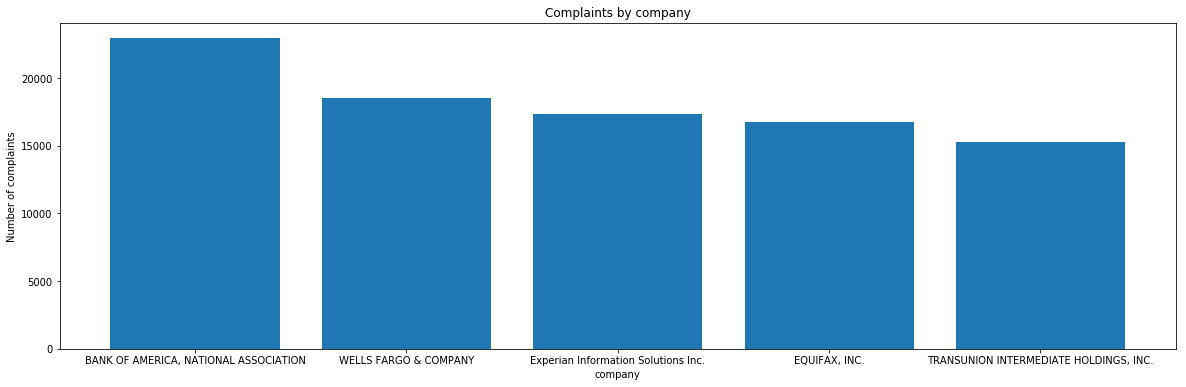

In [145]:
complaints_ordered('state_complaints.csv','company',5)
# The five most complained about companies to the CFPB are Bank Of America,
# Wells Fargo, Experian, Equifax, and Transunion

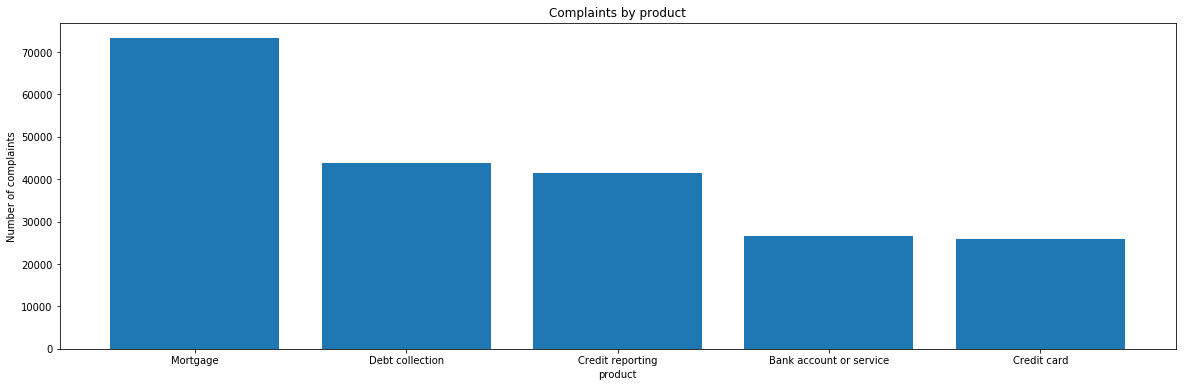

In [146]:
complaints_ordered('state_complaints.csv','product',5)
# The five most complained about products to the CFPB are mortgages, debt
# collection, credit reports, bank accounts, and credit cards

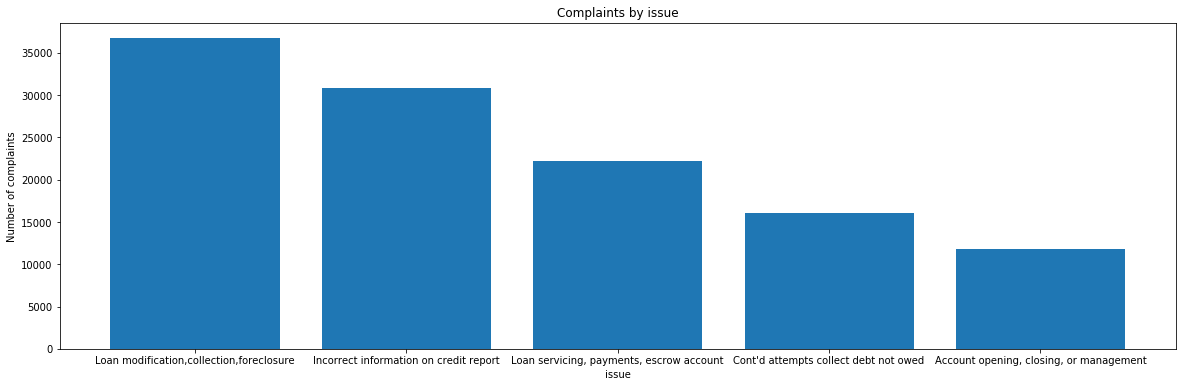

In [147]:
complaints_ordered('state_complaints.csv','issue',5)
# The give most complained about issues to the CFPB are loan modifications/
# collections/foreclosures, incorrect information on credit reports, loan
# servicing/payments, escrow account issues, aggressive debt collection on
# debts that are not owed, and account opening/closing/management

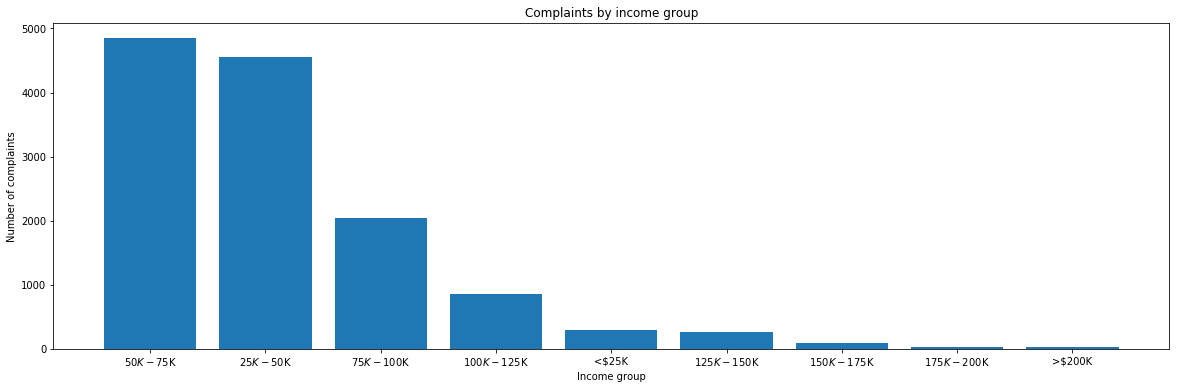

In [160]:
complaints_by_income_group('median_income_by_zip.csv')
# This graph shows the median income per zip code corresponding to 
# the origination of complaints filed to the CFPB by order of greatest to
# least

In [169]:
visualization("top_company_complaints_per_state.csv",'company','per_pop')
# Shows the level of complaints about specific companies proportional to 
# population, with brighter blue indicating a higher level of complaints

In [170]:
visualization("top_company_complaints_per_state.csv",'company','num_of_complaints')
# Shows the number of complaints about specific companies proportional to 
# population, with brighter blue indicating a higher number of complaints

In [171]:
visualization("top_product_complaints_per_state.csv",'product','per_pop')
# Shows the level of complaints about specific products proportional to 
# population, with brighter blue indicating a higher level of complaints

In [172]:
visualization("top_product_complaints_per_state.csv",'product','num_of_complaints')
# Shows the number of complaints about specific products proportional to 
# population, with brighter blue indicating a higher number of complaints

In [173]:
visualization("top_issue_complaints_per_state.csv",'issue','per_pop')
# Shows the level of complaints about specific issues proportional to 
# population, with brighter blue indicating a higher level of complaints

In [174]:
visualization("top_issue_complaints_per_state.csv",'issue','num_of_complaints')
# Shows the number of complaints about specific issues proportional to 
# population, with brighter blue indicating a higher number of complaints